# Graph Attention Networks
> Chapter 2 of the [Graph Neural Network Course](https://github.com/mlabonne/Graph-Neural-Network-Course)

❤️ Created by [@maximelabonne](https://twitter.com/maximelabonne).

Companion notebook to execute the code from the following article: https://mlabonne.github.io/blog/gat/

In [29]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import gc

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [30]:
!pip install torch --upgrade
!pip install torch-geometric torch-sparse torch-scatter --upgrade

# Dataset

In [31]:
from torch_geometric.datasets import Reddit
import torch

# Load the dataset
dataset = Reddit(root=".")
data = dataset[0]


subset_nodes = torch.arange(0, 5000)  # Adjust this range based on your needs

# Create a subgraph with the selected nodes
sub_data = data.subgraph(subset_nodes)

# Print information about the smaller dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {sub_data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {sub_data.is_directed()}')
print(f'Graph has isolated nodes: {sub_data.has_isolated_nodes()}')
print(f'Graph has loops: {sub_data.has_self_loops()}')


Dataset: Reddit()
-------------------
Number of graphs: 1
Number of nodes: 5000
Number of features: 602
Number of classes: 41

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [32]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(sub_data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 762


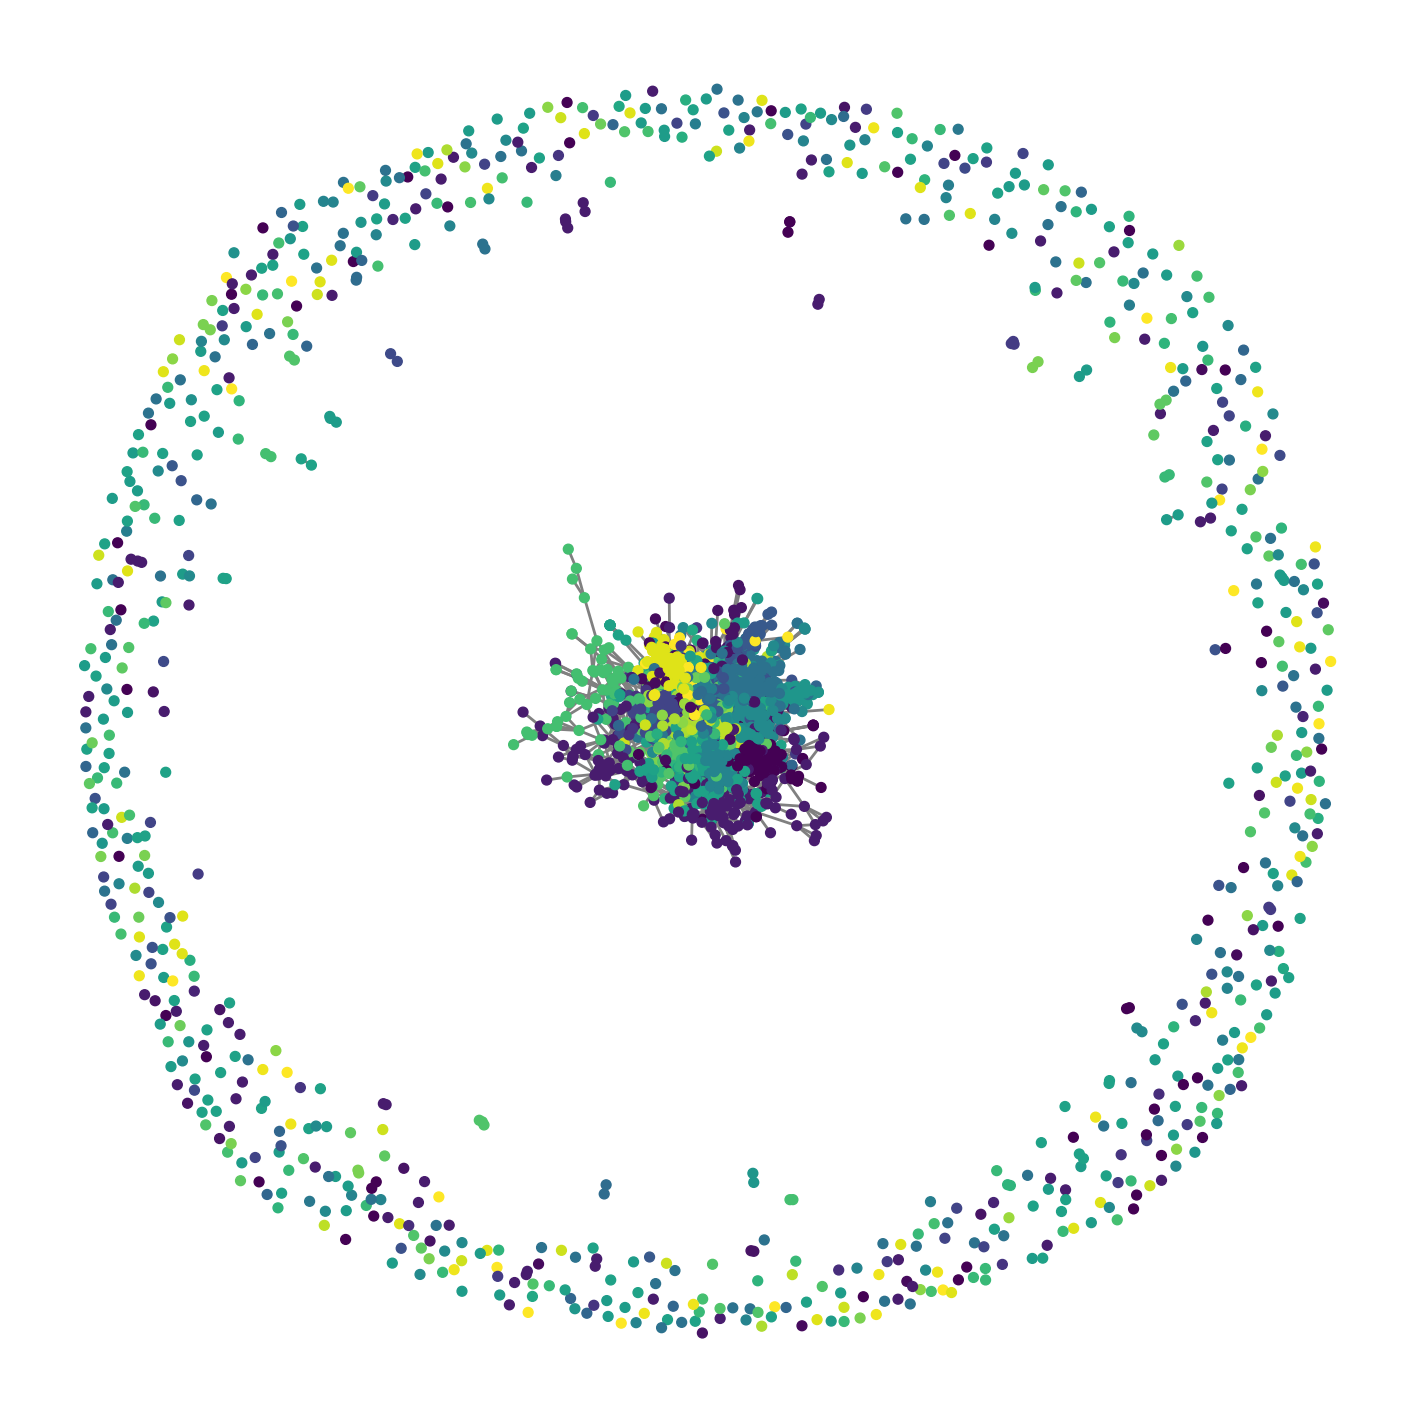

In [33]:
from torch_geometric.utils import to_networkx

G = to_networkx(sub_data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=sub_data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

In [34]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GCN

In [35]:
%%time
gc.collect()
torch.cuda.empty_cache()
# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, sub_data)

# Test
acc = test(gcn, sub_data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(602, 16)
  (gcn2): GCNConv(16, 41)
)
Epoch   0 | Train Loss: 3.972 | Train Acc:   0.69% | Val Loss: 4.03 | Val Acc: 0.62%
Epoch  10 | Train Loss: 2.670 | Train Acc:  36.75% | Val Loss: 2.54 | Val Acc: 43.60%
Epoch  20 | Train Loss: 2.128 | Train Acc:  51.83% | Val Loss: 2.10 | Val Acc: 56.20%
Epoch  30 | Train Loss: 1.817 | Train Acc:  58.00% | Val Loss: 1.94 | Val Acc: 61.78%
Epoch  40 | Train Loss: 1.642 | Train Acc:  62.11% | Val Loss: 1.73 | Val Acc: 66.53%
Epoch  50 | Train Loss: 1.506 | Train Acc:  64.72% | Val Loss: 1.80 | Val Acc: 66.32%
Epoch  60 | Train Loss: 1.440 | Train Acc:  69.00% | Val Loss: 1.61 | Val Acc: 69.63%
Epoch  70 | Train Loss: 1.369 | Train Acc:  69.72% | Val Loss: 1.76 | Val Acc: 71.90%
Epoch  80 | Train Loss: 1.323 | Train Acc:  71.01% | Val Loss: 1.69 | Val Acc: 73.14%
Epoch  90 | Train Loss: 1.330 | Train Acc:  70.11% | Val Loss: 1.65 | Val Acc: 73.97%
Epoch 100 | Train Loss: 1.234 | Train Acc:  71.04% | Val Loss: 1.74 | Val Acc: 72

# Train GAT

In [36]:
%%time
gc.collect()
torch.cuda.empty_cache()

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, sub_data)

# Test
acc = test(gat, sub_data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(602, 8, heads=8)
  (gat2): GATv2Conv(64, 41, heads=1)
)
Epoch   0 | Train Loss: 4.211 | Train Acc:   3.21% | Val Loss: 4.14 | Val Acc: 2.07%
Epoch  10 | Train Loss: 1.578 | Train Acc:  64.24% | Val Loss: 1.61 | Val Acc: 66.74%
Epoch  20 | Train Loss: 0.937 | Train Acc:  79.11% | Val Loss: 1.11 | Val Acc: 78.10%
Epoch  30 | Train Loss: 0.634 | Train Acc:  83.75% | Val Loss: 0.93 | Val Acc: 80.58%
Epoch  40 | Train Loss: 0.480 | Train Acc:  87.92% | Val Loss: 0.92 | Val Acc: 83.47%
Epoch  50 | Train Loss: 0.375 | Train Acc:  90.53% | Val Loss: 0.94 | Val Acc: 83.06%
Epoch  60 | Train Loss: 0.288 | Train Acc:  92.51% | Val Loss: 0.94 | Val Acc: 82.44%
Epoch  70 | Train Loss: 0.245 | Train Acc:  93.94% | Val Loss: 0.99 | Val Acc: 83.88%
Epoch  80 | Train Loss: 0.197 | Train Acc:  95.14% | Val Loss: 1.05 | Val Acc: 82.02%
Epoch  90 | Train Loss: 0.174 | Train Acc:  95.98% | Val Loss: 1.04 | Val Acc: 81.82%
Epoch 100 | Train Loss: 0.149 | Train Acc:  96.13% | Val Los

# t-SNE plots

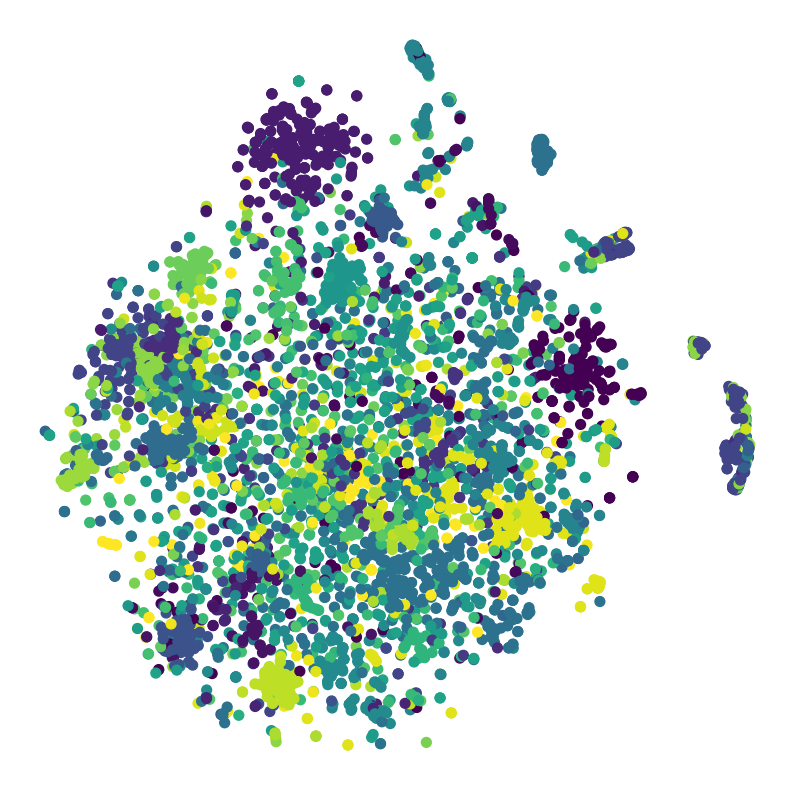

In [37]:
gc.collect()
torch.cuda.empty_cache()
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(sub_data.x, sub_data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=sub_data.y)
plt.show()

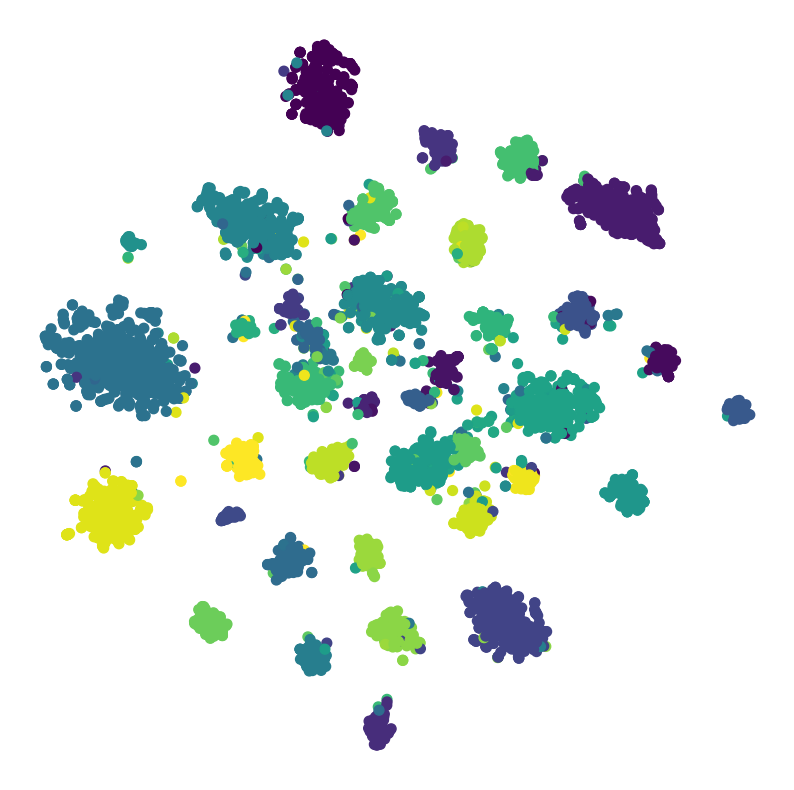

In [38]:
# Get embeddings
h, _ = gat(sub_data.x, sub_data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=sub_data.y)
plt.show()

# Plot accuracy for each node degree

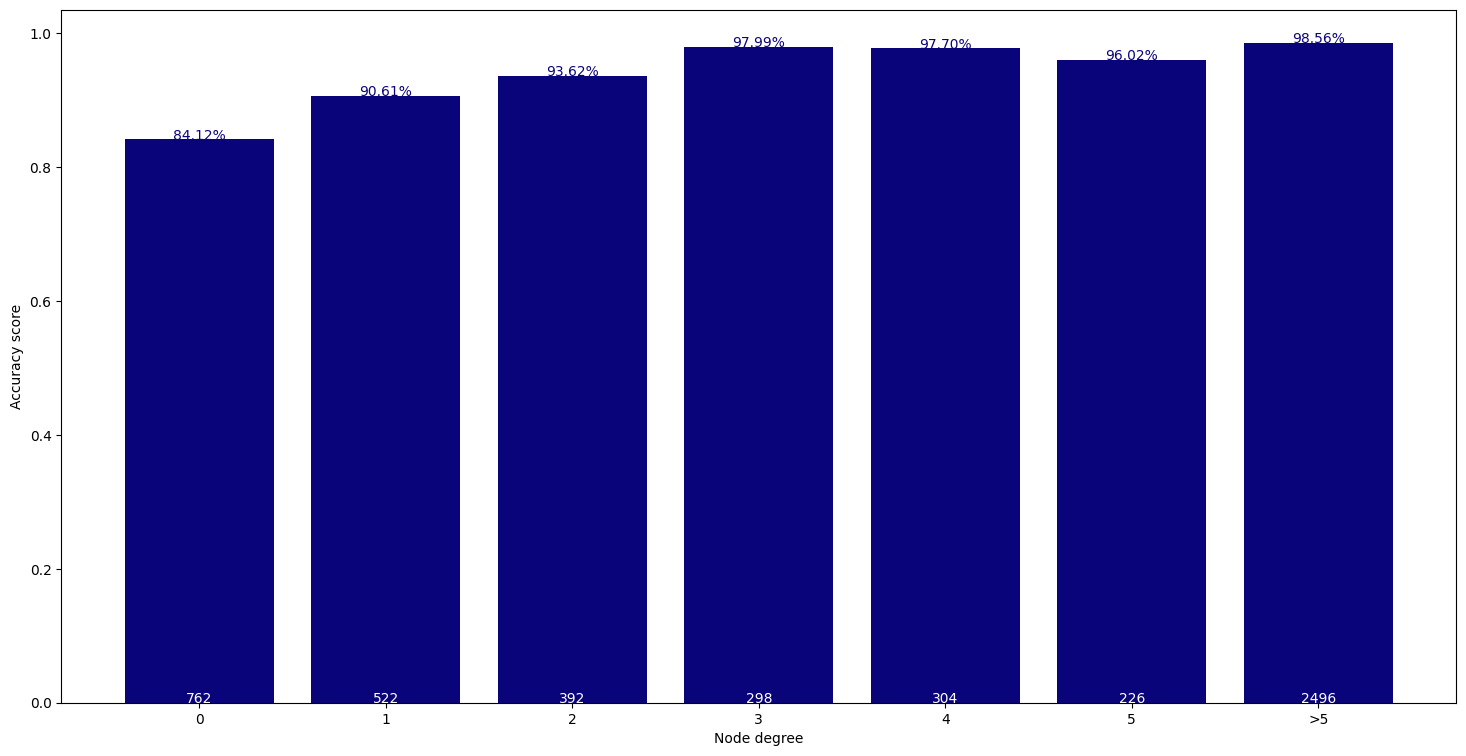

In [39]:
from torch_geometric.utils import degree

# Get model's classifications
_, out = gat(sub_data.x, sub_data.edge_index)

# Calculate the degree of each node
degrees = degree(sub_data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], sub_data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], sub_data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

→ Continue the Graph Neural Network Course with [chapter 3 about GraphSAGE](https://colab.research.google.com/drive/1udeUfWJzvMlLO7sGUDGsHo8cRPMicajl?usp=sharing).